Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic

# Solver
Detailed explanation in [ README.md ](README.md)

In [10]:
class KnapsackSolver:
    """
        Multidimensional 0-1 Knapsack solver.

    """
    def __init__(self, num_knapsacks: int, num_items: int, num_dimensions: int, values: np.ndarray, weights: np.ndarray, constraints: np.ndarray):
        self.num_knapsacks = num_knapsacks
        self.num_items = num_items
        self.num_dimensions = num_dimensions
        self.values = values
        self.weights = weights
        self.constraints = constraints

    def tweak(self, solution: np.ndarray) -> None:
        """
        Tweak the solution by randomly adding/removing items and/or swapping items between knapsacks
        """
        # Randomly select a knapsack and an item
        knapsack = np.random.randint(0, self.num_knapsacks)
        item = np.random.randint(0, self.num_items)

        # Toggle the presence of the item in the selected knapsack
        if solution[knapsack, item]:                    # If item is taken by current knapsack
            solution[knapsack, item] = False
        elif not np.any(solution[:, item], axis=0):     # Item is not taken by any knapsack
            solution[knapsack, item] = True             

        # Randomly swap two items between two knapsacks
        # knapsack1, knapsack2 = np.random.choice(self.num_knapsacks, size=2, replace=False)
        # item1 = np.random.randint(0, self.num_items)
        # item2 = np.random.randint(0, self.num_items)

        # solution[knapsack1, item1], solution[knapsack2, item2] = solution[knapsack2, item2], solution[knapsack1, item1]

        return solution


    def fitness(self, solution: np.ndarray) -> int:
        # If the solution is not feasible, return a large negative penalty
        if not self.feasible(solution):
            return -1e3
        # Returns the sum of values of the items in the knapsacks
        return sum(self.values[np.any(solution, axis=0)])

    def feasible(self, solution: np.ndarray) -> bool:
        # Check that the same object does not appear in multiple knapsacks
        if not np.all(solution.sum(axis=0) <= 1):
            return False
        # Check if the solution is valid
        for k in range(self.num_knapsacks):
            if np.any(self.weights[solution[k]].sum(axis=0) > self.constraints[k]):
                return False
        return True

    def make_feasible(self, solution: np.ndarray) -> np.ndarray:
        """
        Make the solution feasible by removing items until it is valid
        """
        while not self.feasible(solution):
            knapsack = np.random.randint(0, self.num_knapsacks)
            items_in_knapsack = np.where(solution[knapsack])[0]
            if len(items_in_knapsack) == 0:
                continue
            item_to_remove = np.random.choice(items_in_knapsack)
            solution[knapsack, item_to_remove] = False
        return solution

    def solve_knapsack(self, initial_solution=None, max_iter: int = 1000, eps: float = 1e-2, verbose: bool = False) -> tuple[np.ndarray, int]:
        if initial_solution is None:
            solution = np.zeros((self.num_knapsacks, self.num_items), dtype=bool)
        else:
            solution = initial_solution

        solution = self.make_feasible(solution)

        # Keep global best solution
        best_solution = solution.copy()
        best_fitness = self.fitness(best_solution)


        # Current solution that updates over time
        cur_solution = solution.copy()    
        cur_fitness = self.fitness(cur_solution)


        # Keep track of fitness history for plotting
        self.best_fitness_history = [0] * (max_iter + 1)
        self.cur_fitness_history = [0] * (max_iter + 1)

        self.best_fitness_history[0] = best_fitness
        self.cur_fitness_history[0] = cur_fitness

        for iteration in range(max_iter):
            new_solution = self.tweak(cur_solution.copy())

            if not self.feasible(new_solution):
                pass
            new_fitness = self.fitness(new_solution)
            if new_fitness > best_fitness:
                best_solution = new_solution.copy()
                best_fitness = new_fitness

            if new_fitness > cur_fitness:
                cur_solution = new_solution
                cur_fitness = new_fitness

                if verbose:
                    ic(iteration, best_fitness, cur_fitness)
            elif new_fitness >= 0:   # Ensure solution is still feasible
                # Accept with a small probability even if worse (simulated annealing)
                if np.random.random() < eps:
                    cur_solution = new_solution
                    cur_fitness = new_fitness

            self.best_fitness_history[iteration+1] = best_fitness
            self.cur_fitness_history[iteration+1] = cur_fitness

        return best_solution, best_fitness
    
    def plot_knapsack_history(self) -> None:
        plt.loglog(self.best_fitness_history, label='Best Fitness')
        plt.loglog(self.cur_fitness_history, label='Current Fitness')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness')
        plt.title('Knapsack Problem Fitness Over Iterations')
        plt.legend()
        plt.show()

## TEST PROBLEMS

In [11]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

Solution is feasible: True
Total value achieved (Solution fitness): 1065


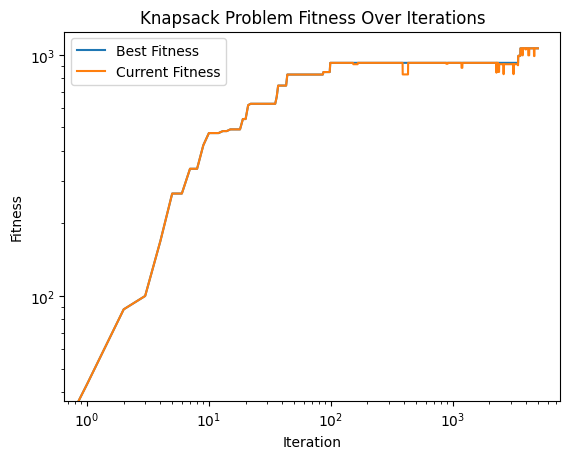

In [12]:
solver = KnapsackSolver(NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS)
solution, fitness = solver.solve_knapsack(max_iter=5000, eps=1e-2)
print("Solution is feasible:", solver.feasible(solution))
print("Total value achieved (Solution fitness):", fitness)
solver.plot_knapsack_history()

In [13]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

Solution is feasible: True
Total value achieved (Solution fitness): 30340


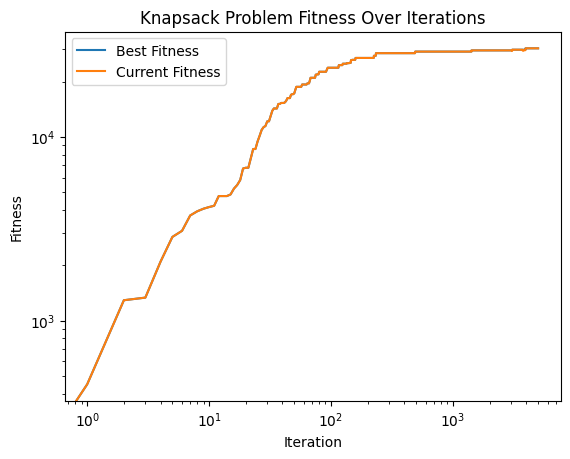

In [14]:
solver = KnapsackSolver(NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS)
solution, fitness = solver.solve_knapsack(max_iter=5000, eps=1e-2)
print("Solution is feasible:", solver.feasible(solution))
print("Total value achieved (Solution fitness):", fitness)
solver.plot_knapsack_history()

In [15]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

Solution is feasible: True
Total value achieved (Solution fitness): 1089106


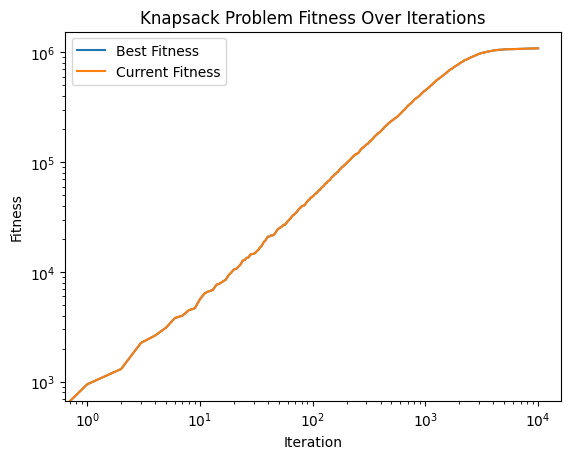

In [16]:
solver = KnapsackSolver(NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS)
solution, fitness = solver.solve_knapsack(max_iter=10000, eps=1e-2)
print("Solution is feasible:", solver.feasible(solution))
print("Total value achieved (Solution fitness):", fitness)
solver.plot_knapsack_history()